# demo.py - Credit Default Risk Pipeline (phiên bản chuẩn, sạch, không over-processing)

Các bước chính:
1. Load dữ liệu + phân tích
2. Kiểm tra & xử lý chất lượng dữ liệu (missing, giá trị âm, outlier nhẹ)
3. Train/test split
4. Cân bằng dữ liệu bằng SMOTE
5. Scaling (tuỳ chọn, giữ để dùng thêm Logistic/XGBoost sau này)
6. Train RandomForest
7. Tuning threshold để tối ưu F1-score
8. In kết quả so sánh: threshold 0.5 vs threshold tối ưu

# Import thư viện

In [106]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
import math

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
print('✅ Đã import thư viện & cấu hình plotting.')


✅ Đã import thư viện & cấu hình plotting.


# Đọc DL

In [107]:
data_path = 'super_dirty_default_credit.csv'

print('📂 Đọc dữ liệu từ:', data_path)
df_dirty = pd.read_csv(data_path)
print('✅ Shape:', df_dirty.shape)
df_dirty.head()

📂 Đọc dữ liệu từ: super_dirty_default_credit.csv
✅ Shape: (30000, 25)
✅ Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaultpaymentnextmonth
0,NaN,NaN,1.915599,2.197883,0.965275,23.860783,0.099860,NaN,-0.921614,NaN,...,18373.073181,8109.905591,NaN,35172.426149,NaN,NaN,-1133.571449,-3466.735371,NaN,0
1,-18.670861,118112.379226,NaN,1.981436,1.860583,27.462270,0.076153,0.072428,-0.112642,-0.156686,...,8942.241259,NaN,-9996.079032,71336.035934,285406.730834,144472.427553,NaN,NaN,-2863.981400,1
2,NaN,NaN,1.959610,1.892543,1.982761,33.403386,0.001817,-0.165581,-0.479042,NaN,...,15990.296025,32783.919349,24134.070521,90720.343829,100258.778836,92905.856719,3622.995244,NaN,NaN,0
3,587.274422,51115.787436,NaN,2.205413,0.925169,NaN,NaN,0.203892,-0.186767,-0.202249,...,21646.160963,NaN,28912.149636,NaN,9647.734419,129223.192194,2528.235725,386.943302,6892.974890,0
4,-520.790966,59915.092259,0.993388,1.869776,1.007114,NaN,NaN,NaN,NaN,0.149910,...,NaN,13875.402045,14297.355203,-2901.469158,NaN,36238.551081,11403.071835,1633.308547,1324.381449,0


# EDA

## xác định target + phân loại đặc trưng

In [108]:
target_col = 'defaultpaymentnextmonth'
print('🎯 Cột target:', target_col)

numeric_cols = df_dirty.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = [c for c in df_dirty.columns if c not in numeric_cols + [target_col]]
print('📌 Numeric cols:', numeric_cols)
print('📌 Categorical cols:', categorical_cols)

🎯 Cột target: defaultpaymentnextmonth
📌 Numeric cols: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
📌 Categorical cols: []


## Tổng quan về data

In [109]:
print('📌 Thông tin tổng quan dataset:')
df_dirty.info()

📌 Thông tin tổng quan dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       22621 non-null  float64
 1   LIMIT_BAL                22851 non-null  float64
 2   SEX                      22510 non-null  float64
 3   EDUCATION                22467 non-null  float64
 4   MARRIAGE                 22555 non-null  float64
 5   AGE                      22784 non-null  float64
 6   PAY_0                    22476 non-null  float64
 7   PAY_2                    22486 non-null  float64
 8   PAY_3                    22519 non-null  float64
 9   PAY_4                    22368 non-null  float64
 10  PAY_5                    22518 non-null  float64
 11  PAY_6                    22368 non-null  float64
 12  BILL_AMT1                22445 non-null  float64
 13  BILL_AMT2                22512 non-null  floa

## EDA: Missing

📌 Tổng quan Missing Values:


,Missing Count,Missing %
BILL_AMT5,7672,25.57
PAY_4,7632,25.44
PAY_6,7632,25.44
PAY_AMT4,7557,25.19
BILL_AMT1,7555,25.18
BILL_AMT6,7546,25.15
PAY_AMT1,7541,25.14
EDUCATION,7533,25.11
PAY_0,7524,25.08
PAY_2,7514,25.05


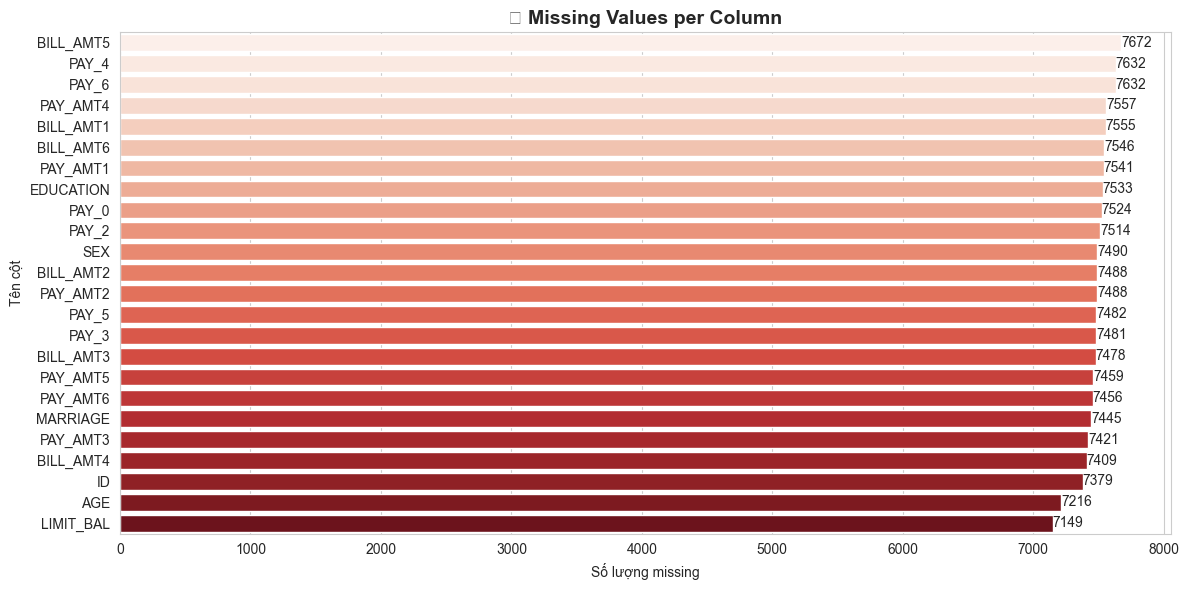

In [110]:
# ================================
# 1. Tính missing
# ================================
missing = df_dirty.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("📌 Tổng quan Missing Values:")
display(
    pd.DataFrame({
        "Missing Count": missing,
        "Missing %": (missing / len(df_dirty) * 100).round(2)
    })
)

# ================================
# 2. Vẽ biểu đồ rõ ràng hơn
# ================================
plt.figure(figsize=(12, 6))

# dùng color gradient theo % missing
colors = sns.color_palette("Reds", len(missing))

sns.barplot(
    x=missing.values,
    y=missing.index,
    palette=colors
)

plt.title("🔥 Missing Values per Column", fontsize=14, fontweight="bold")
plt.xlabel("Số lượng missing")
plt.ylabel("Tên cột")

# hiển thị số value bên cạnh bar
for i, v in enumerate(missing.values):
    plt.text(v + 0.05, i, str(v), va='center')

plt.tight_layout()
plt.show()

## EDA: Phân bố Target

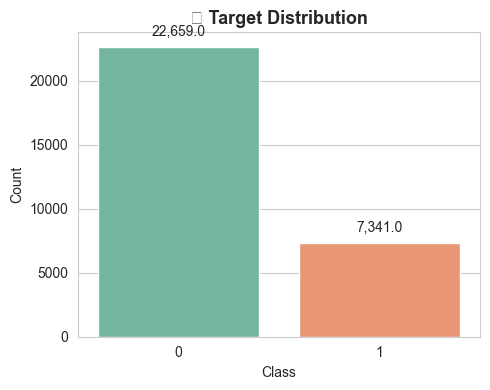

In [111]:
# =============================
# 1. Biểu đồ phân bố Target
# =============================
plt.figure(figsize=(5, 4))

ax = sns.countplot(
    x=target_col,
    data=df_dirty,
    palette="Set2"
)

# Thêm nhãn số lượng ngay trên cột
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.02 * df_dirty.shape[0],
        f"{height:,}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("📊 Target Distribution", fontsize=13, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# # =============================
# # 2. Tỷ lệ phân lớp
# # =============================
# print("\n📌 Tỷ lệ phân lớp (%):")

# ratio_df = (
#     df_dirty[target_col]
#     .value_counts(normalize=True)
#     .mul(100)
#     .round(2)
#     .rename("Percentage (%)")
#     .to_frame()
# )

# display(ratio_df)


## EDA: Phân bố biến chính - numeric

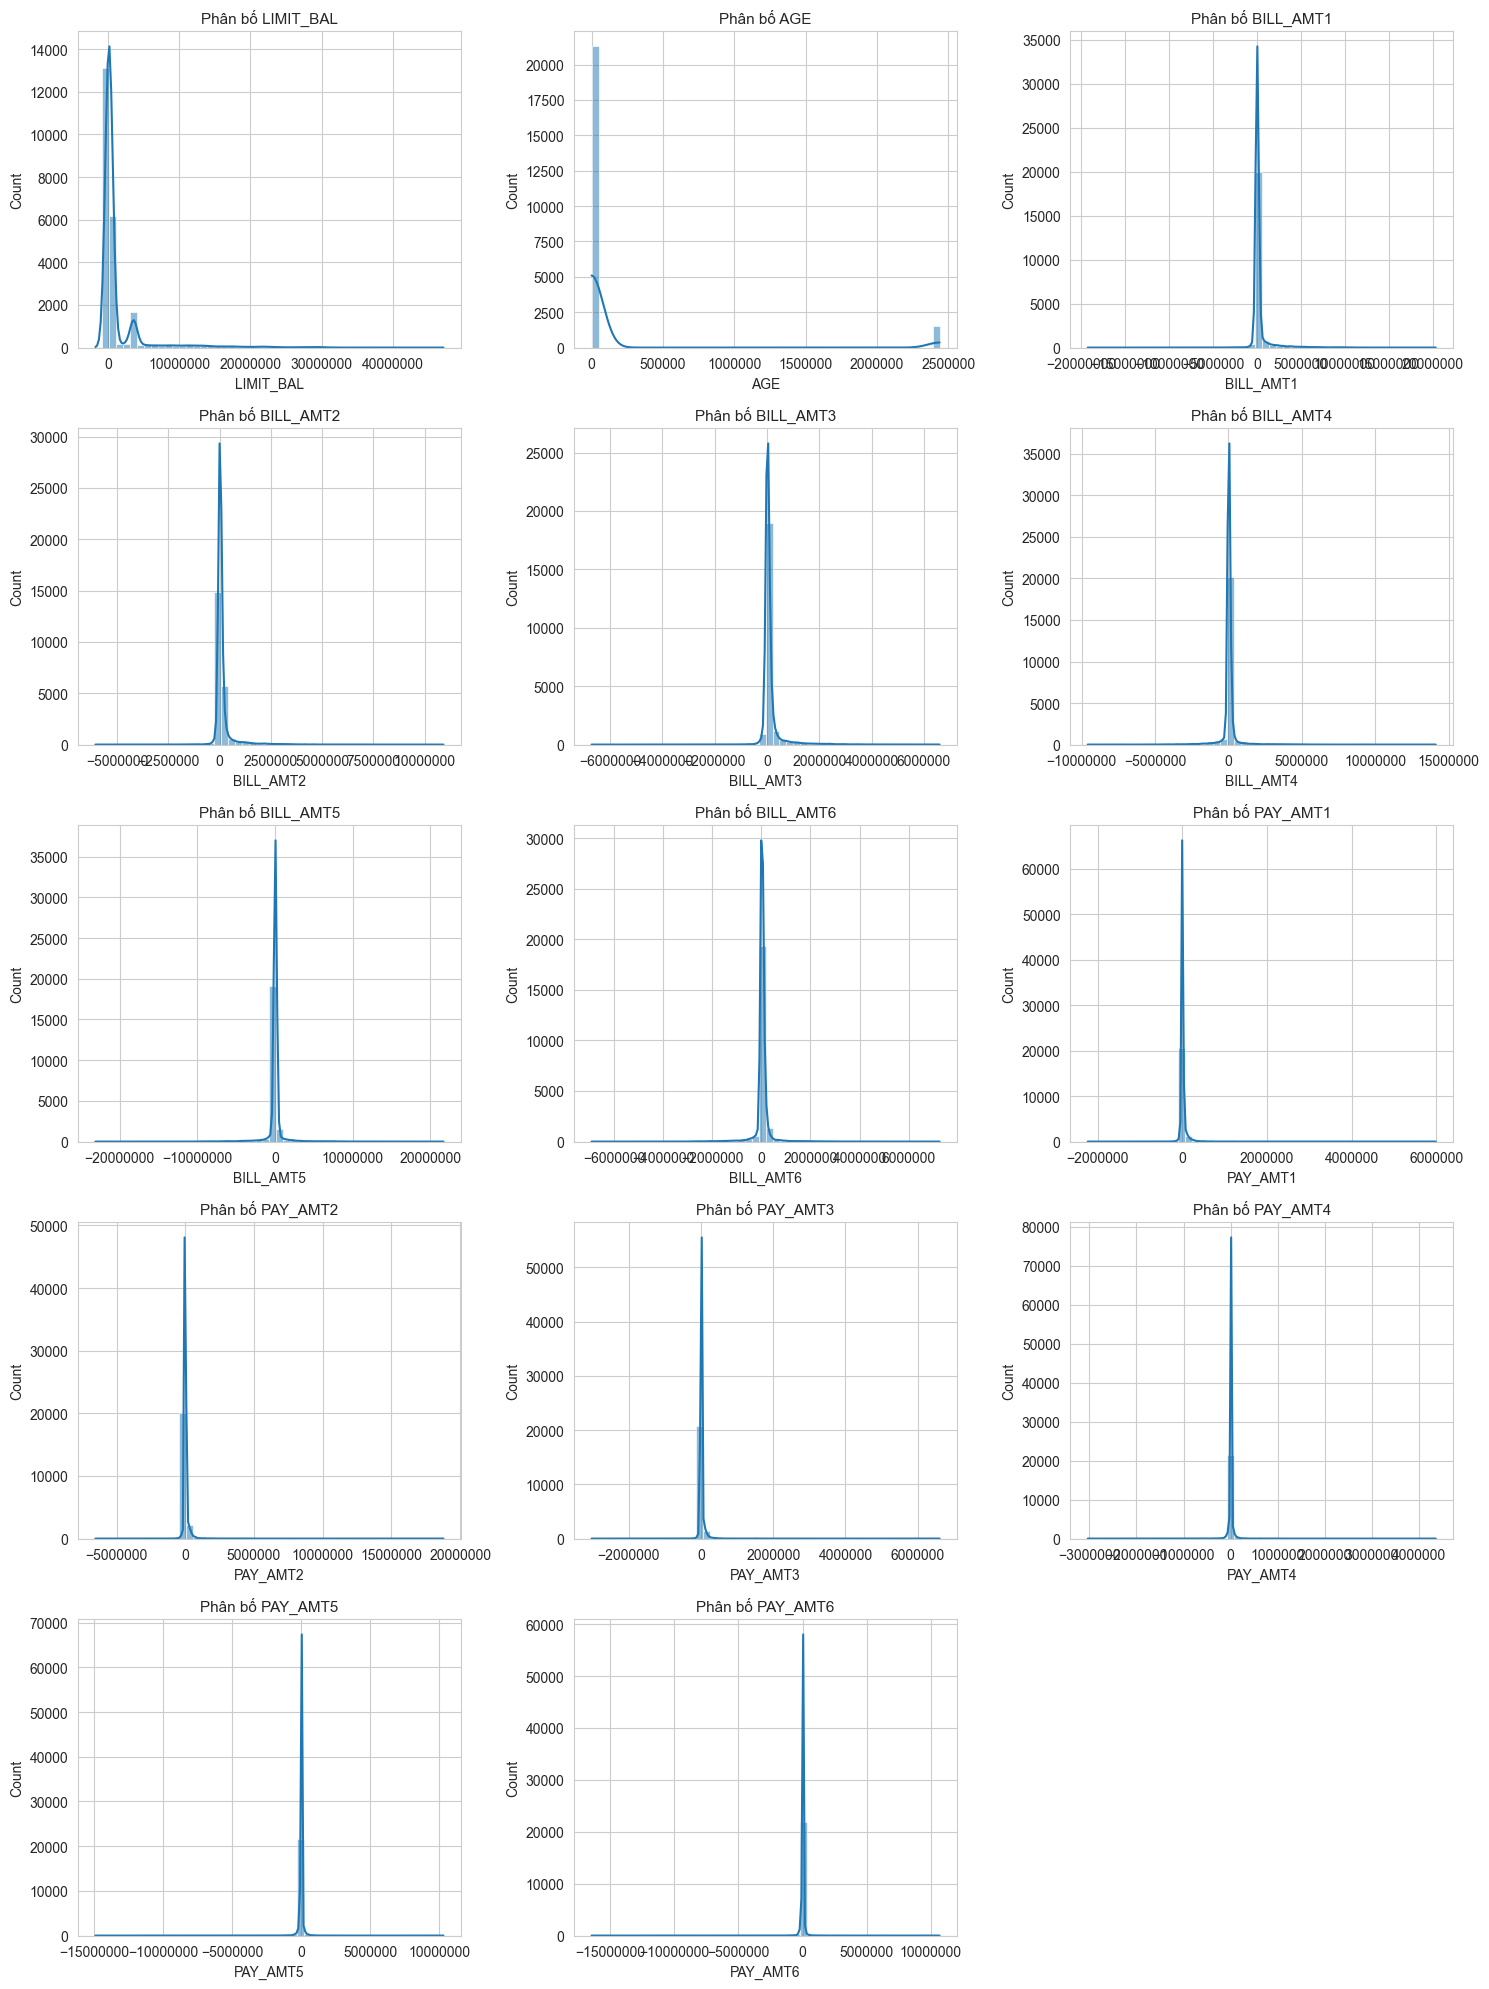

In [112]:
# Danh sách cột cần vẽ histogram
numeric_cols_toplot = ['LIMIT_BAL', 'AGE'] + \
    [f'BILL_AMT{i}' for i in range(1, 7)] + \
    [f'PAY_AMT{i}' for i in range(1, 7)]
numeric_cols_toplot = [c for c in numeric_cols_toplot if c in df_dirty.columns]

# Số lượng biểu đồ
n_cols = 3   # số cột trong grid
n_plots = len(numeric_cols_toplot)
n_rows = math.ceil(n_plots / n_cols)

# Tạo grid figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_toplot):
    sns.histplot(df_dirty[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Phân bố {col}', fontsize=11)
    axes[i].ticklabel_format(style='plain')  # tránh scientific notation

# Ẩn ô dư
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## EDA: Outliers


🔎 **Phân tích Outliers – LIMIT_BAL**
- Q1: 71,030.80
- Q3: 349,499.04
- IQR: 278,468.24
- Ngưỡng dưới: -346,671.56
- Ngưỡng trên: 767,201.41
- Số outliers phát hiện: 3,629 (15.88%)


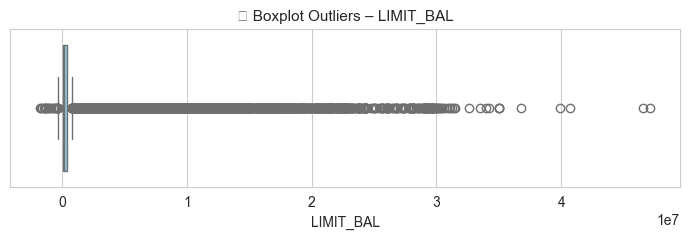


🔎 **Phân tích Outliers – AGE**
- Q1: 29.17
- Q3: 48.79
- IQR: 19.62
- Ngưỡng dưới: -0.26
- Ngưỡng trên: 78.22
- Số outliers phát hiện: 3,763 (16.52%)


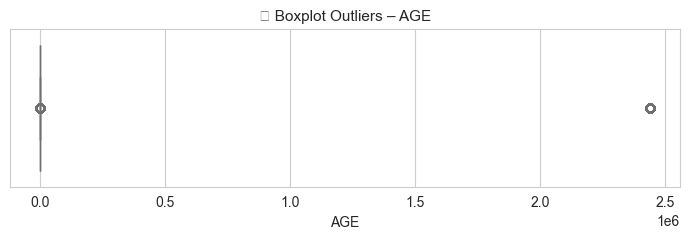


🔎 **Phân tích Outliers – BILL_AMT1**
- Q1: 2,738.85
- Q3: 93,512.24
- IQR: 90,773.40
- Ngưỡng dưới: -133,421.25
- Ngưỡng trên: 229,672.34
- Số outliers phát hiện: 3,681 (16.40%)


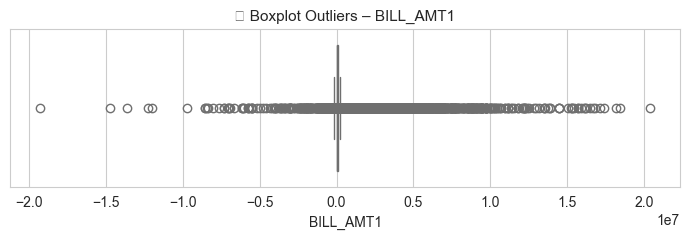


🔎 **Phân tích Outliers – PAY_AMT1**
- Q1: -53.04
- Q3: 7,590.82
- IQR: 7,643.86
- Ngưỡng dưới: -11,518.82
- Ngưỡng trên: 19,056.60
- Số outliers phát hiện: 3,963 (17.65%)


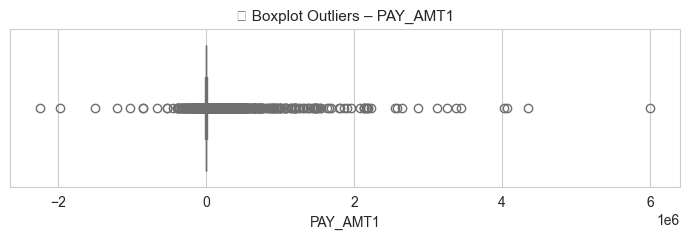

In [113]:
cols_to_check = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1']

for col in cols_to_check:
    if col not in df_dirty.columns:
        continue

    series = df_dirty[col].dropna()

    # =======================
    # 1. PHÂN TÍCH SƠ BỘ OUTLIERS
    # =======================
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    outlier_ratio = (len(outliers) / len(series)) * 100

    print(f"\n🔎 **Phân tích Outliers – {col}**")
    print(f"- Q1: {Q1:,.2f}")
    print(f"- Q3: {Q3:,.2f}")
    print(f"- IQR: {IQR:,.2f}")
    print(f"- Ngưỡng dưới: {lower_bound:,.2f}")
    print(f"- Ngưỡng trên: {upper_bound:,.2f}")
    print(f"- Số outliers phát hiện: {len(outliers):,} ({outlier_ratio:.2f}%)")

    # =======================
    # 2. BIỂU ĐỒ BOXPLOT
    # =======================
    plt.figure(figsize=(7, 2.5))
    sns.boxplot(x=series, color="skyblue")
    plt.title(f'📦 Boxplot Outliers – {col}', fontsize=11)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


## EDA: Correlation Heatmap

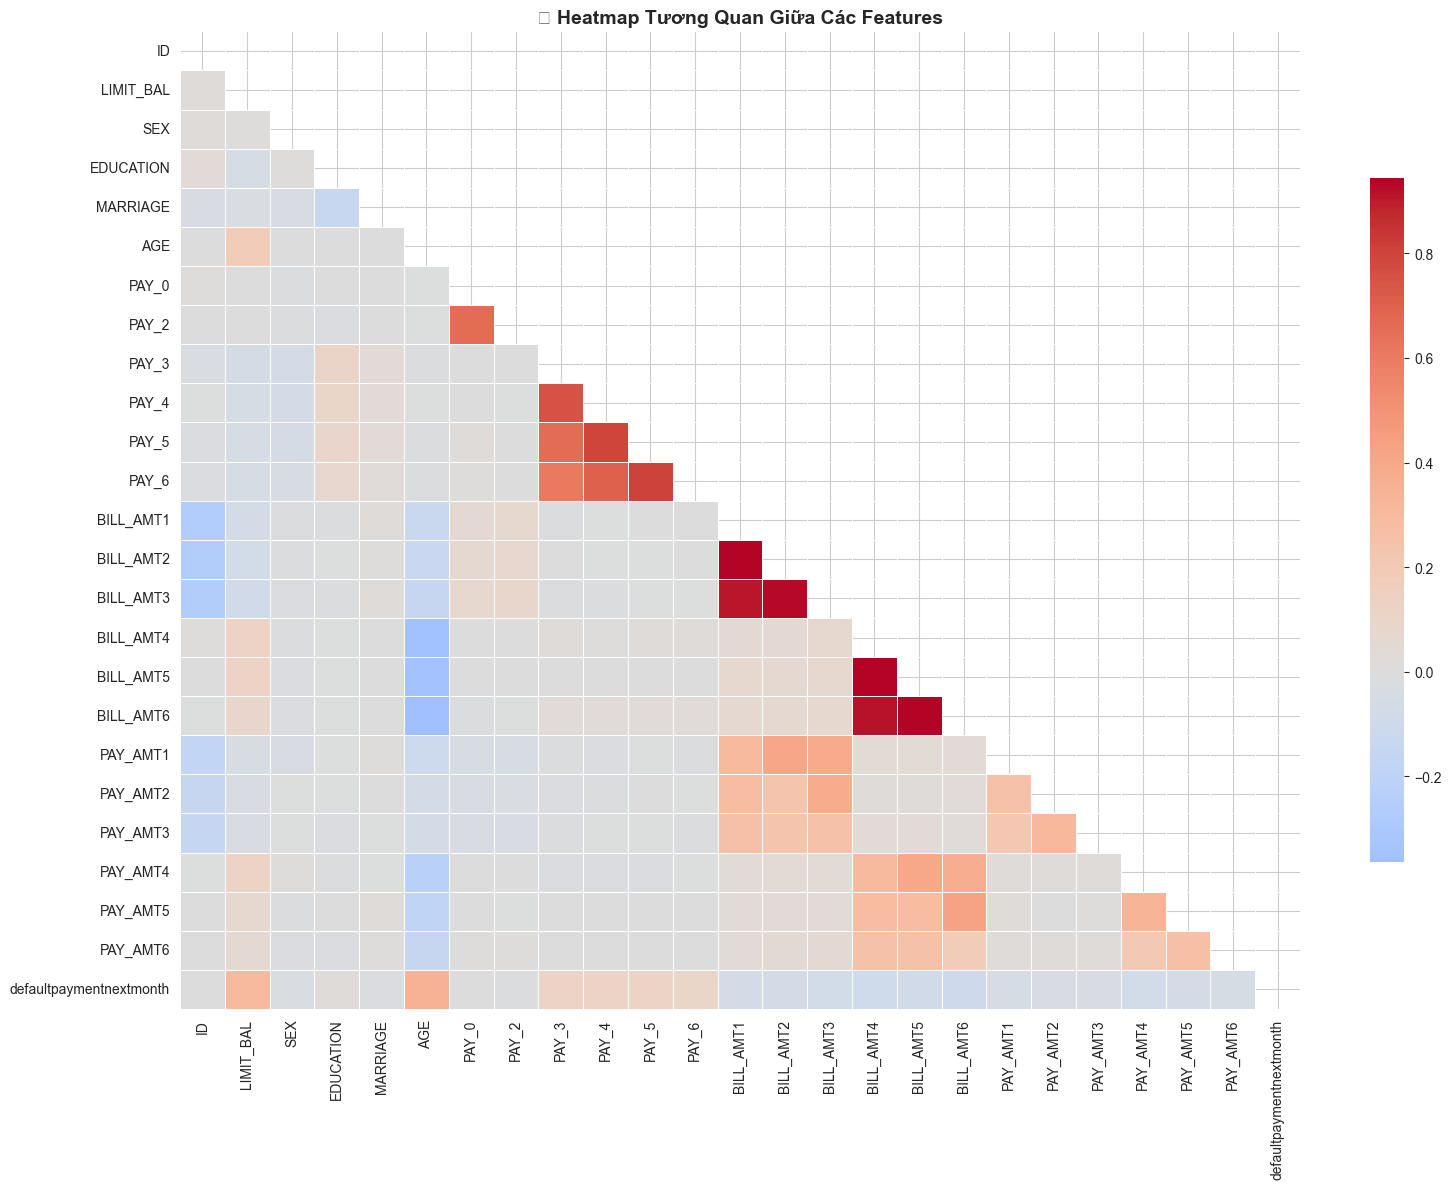

In [114]:
# Tính ma trận tương quan
corr_matrix = df_dirty.corr()

plt.figure(figsize=(16, 12))

# Heatmap với cải tiến: annot nhỏ, mask nửa trên, palette dễ nhìn
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,             # chỉ hiển thị nửa dưới để đỡ rối
    cmap='coolwarm',
    center=0,
    annot=False,           # annot=True quá rối vì dataset nhiều cột
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)

plt.title('🔍 Heatmap Tương Quan Giữa Các Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## EDA: BILL_AMT vs PAY_AMT

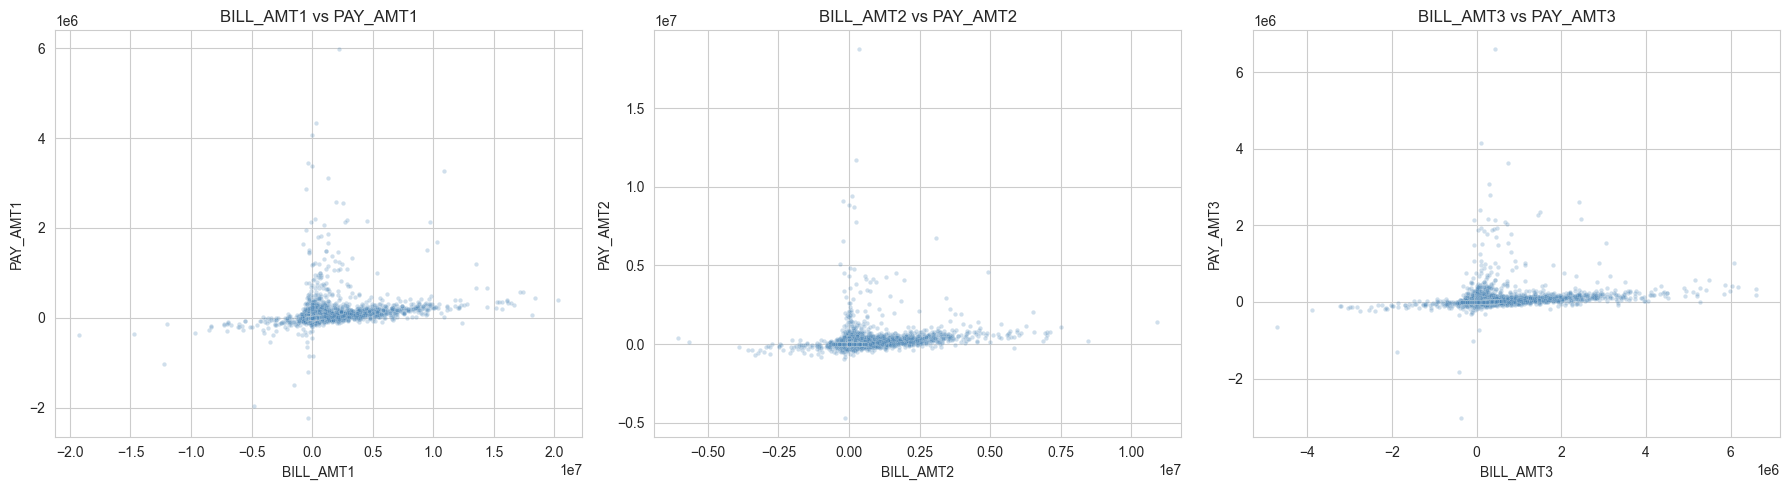

In [115]:
pairs = [
    ('BILL_AMT1', 'PAY_AMT1'),
    ('BILL_AMT2', 'PAY_AMT2'),
    ('BILL_AMT3', 'PAY_AMT3'),
]

valid_pairs = [(b, p) for b, p in pairs if b in df_dirty.columns and p in df_dirty.columns]

n = len(valid_pairs)
n_cols = 3
n_rows = 1

plt.figure(figsize=(18, 5))

for i, (bill, pay) in enumerate(valid_pairs):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(
        x=df_dirty[bill],
        y=df_dirty[pay],
        alpha=0.25,
        s=10,
        color='steelblue'
    )
    plt.title(f'{bill} vs {pay}')
    plt.xlabel(bill)
    plt.ylabel(pay)

plt.tight_layout()
plt.show()


## EDA: Tính hợp lệ

In [116]:
print("🔍 KIỂM TRA DỮ LIỆU BẤT THƯỜNG".upper())
print("="*55)

# ===============================
# 1. Giá trị âm trong numeric columns
# ===============================
print("\n📌 1. Các giá trị âm trong dữ liệu:")

negative_info = []
for col in numeric_cols:
    if df_dirty[col].dtype != "object":
        neg = (df_dirty[col] < 0).sum()
        if neg > 0:
            negative_info.append([col, neg, round(neg / len(df_dirty) * 100, 3)])

if len(negative_info) > 0:
    neg_df = pd.DataFrame(negative_info, columns=["Column", "Negative Count", "Percentage (%)"])
    display(neg_df)
else:
    print("→ Không tìm thấy giá trị âm nào.")

# ===============================
# 2. LIMIT_BAL > 1 triệu
# ===============================
print("\n📌 2. LIMIT_BAL > 1,000,000:")

if "LIMIT_BAL" in df_dirty.columns:
    high_limit = (df_dirty["LIMIT_BAL"] > 1e6).sum()
    ratio = round(high_limit / len(df_dirty) * 100, 3)
    print(f"→ Số lượng: {high_limit} ({ratio}%)")
else:
    print("→ Cột LIMIT_BAL không tồn tại.")

# ===============================
# 3. AGE bất thường
# ===============================
print("\n📌 3. AGE bất thường (<18 hoặc >100):")

if "AGE" in df_dirty.columns:
    abnormal_age = ((df_dirty["AGE"] < 18) | (df_dirty["AGE"] > 100)).sum()
    ratio = round(abnormal_age / len(df_dirty) * 100, 3)
    print(f"→ Số lượng: {abnormal_age} ({ratio}%)")
else:
    print("→ Cột AGE không tồn tại.")


🔍 KIỂM TRA DỮ LIỆU BẤT THƯỜNG

📌 1. Các giá trị âm trong dữ liệu:


,Column,Negative Count,Percentage (%)
0,ID,396,1.320
1,LIMIT_BAL,419,1.397
2,EDUCATION,4,0.013
3,MARRIAGE,19,0.063
4,PAY_0,11855,39.517
5,PAY_2,13306,44.353
6,PAY_3,13488,44.960
7,PAY_4,13546,45.153
8,PAY_5,13902,46.340
9,PAY_6,14030,46.767



📌 2. LIMIT_BAL > 1,000,000:
→ Số lượng: 3579 (11.93%)

📌 3. AGE bất thường (<18 hoặc >100):
→ Số lượng: 2106 (7.02%)


## EDA: Correlation với Target

📊 Top 15 Features tương quan mạnh nhất với Target:
AGE          0.347872
LIMIT_BAL    0.299160
PAY_3        0.124972
PAY_4        0.123978
PAY_5        0.116680
PAY_6        0.102798
EDUCATION    0.022728
PAY_0        0.004621
ID           0.000644
PAY_2       -0.008842
MARRIAGE    -0.015184
SEX         -0.025017
PAY_AMT3    -0.028932
PAY_AMT2    -0.031914
PAY_AMT6    -0.042315
Name: defaultpaymentnextmonth, dtype: float64

📉 Top 15 Features tương quan âm mạnh nhất:
PAY_2       -0.008842
MARRIAGE    -0.015184
SEX         -0.025017
PAY_AMT3    -0.028932
PAY_AMT2    -0.031914
PAY_AMT6    -0.042315
PAY_AMT1    -0.043507
BILL_AMT1   -0.060728
PAY_AMT5    -0.061816
BILL_AMT2   -0.066583
PAY_AMT4    -0.073753
BILL_AMT3   -0.076515
BILL_AMT5   -0.082522
BILL_AMT4   -0.092948
BILL_AMT6   -0.095300
Name: defaultpaymentnextmonth, dtype: float64


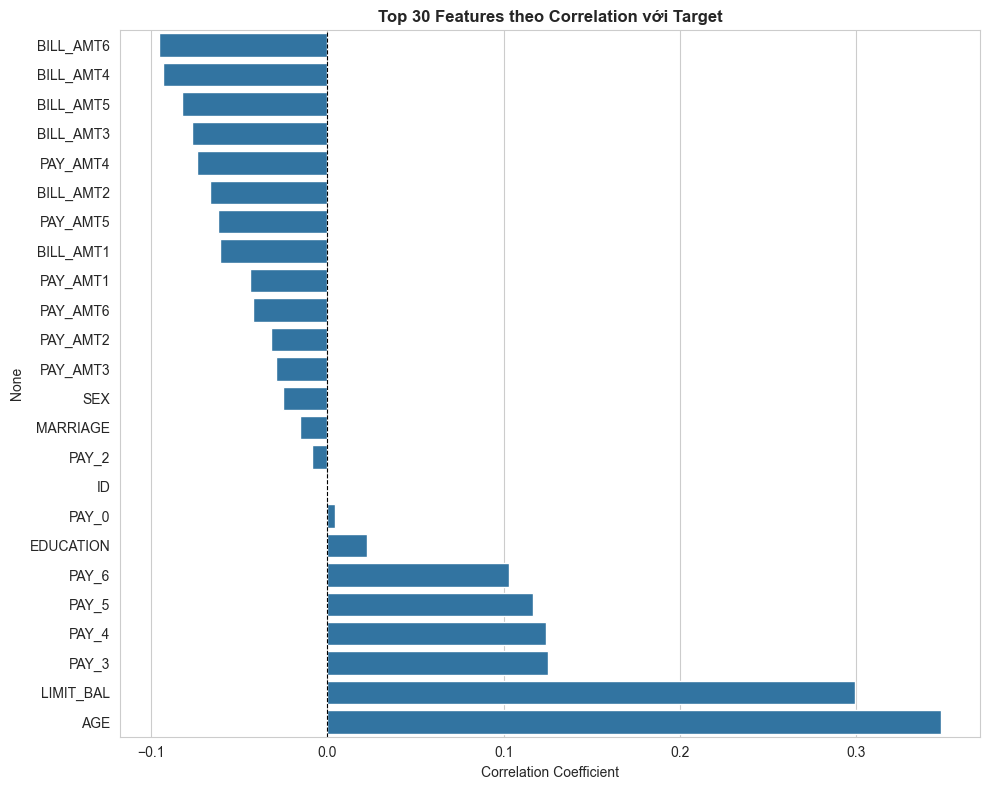

In [117]:
# Tính correlation của các numeric features với target
print('📊 Top 15 Features tương quan mạnh nhất với Target:')
corr_with_target = df_dirty[numeric_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)
print(corr_with_target.head(15))
print('\n📉 Top 15 Features tương quan âm mạnh nhất:')
print(corr_with_target.tail(15))

# Visualization
plt.figure(figsize=(10, 8))
top_corr = pd.concat([corr_with_target.head(15), corr_with_target.tail(15)]).sort_values()
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 30 Features theo Correlation với Target', fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# Baseline Model - Đánh giá trước khi xử lý

Train mô hình trên dữ liệu thô (chưa xử lý) để có baseline so sánh

## Chuẩn bị dữ liệu thô cho Baseline

In [118]:
print('🔥 BASELINE MODEL - ĐÁNH GIÁ DỮ LIỆU THÔ')
print('='*60)
print('⚠️ Mục đích: Train model trên dữ liệu chưa xử lý để có baseline so sánh')
print('='*60)

# Tạo bản copy để xử lý baseline
df_baseline = df_dirty.copy()

# Xử lý missing đơn giản: fill median cho numeric (vì model không chạy được với NaN)
print('\n📌 Xử lý missing đơn giản cho baseline (fillna median)...')
for col in numeric_cols:
    if df_baseline[col].isna().sum() > 0:
        df_baseline[col].fillna(df_baseline[col].median(), inplace=True)

print(f'✅ Missing sau fillna: {df_baseline.isna().sum().sum()}')

# Tách X, y
X_baseline = df_baseline.drop(columns=[target_col])
y_baseline = df_baseline[target_col]

print(f'\n📊 Shape dữ liệu baseline:')
print(f'   X: {X_baseline.shape}')
print(f'   y distribution: {y_baseline.value_counts(normalize=True).round(3).to_dict()}')

🔥 BASELINE MODEL - ĐÁNH GIÁ DỮ LIỆU THÔ
⚠️ Mục đích: Train model trên dữ liệu chưa xử lý để có baseline so sánh

📌 Xử lý missing đơn giản cho baseline (fillna median)...
✅ Missing sau fillna: 0

📊 Shape dữ liệu baseline:
   X: (30000, 24)
   y distribution: {0: 0.755, 1: 0.245}


## Train/Test Split cho Baseline

In [119]:
print('📏 TRAIN/TEST SPLIT CHO BASELINE')
print('='*60)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_baseline, y_baseline,
    test_size=0.2,
    stratify=y_baseline,
    random_state=42
)

print(f'✅ Train: {X_train_base.shape}')
print(f'✅ Test: {X_test_base.shape}')
print(f'\n📊 Train class distribution: {y_train_base.value_counts(normalize=True).round(3).to_dict()}')

📏 TRAIN/TEST SPLIT CHO BASELINE
✅ Train: (24000, 24)
✅ Test: (6000, 24)

📊 Train class distribution: {0: 0.755, 1: 0.245}


## Train Baseline RandomForest

In [120]:
print('🌲 TRAIN BASELINE RANDOMFOREST')
print('='*60)
print('⚠️ Dữ liệu: Thô, chưa xử lý outliers, giá trị âm, chưa SMOTE, chưa scale')

# Train model đơn giản
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    class_weight='balanced',  # vì chưa SMOTE
    random_state=42,
    n_jobs=-1
)

print('\n⏳ Đang train baseline model...')
rf_baseline.fit(X_train_base, y_train_base)
print('✅ Đã train xong!')

🌲 TRAIN BASELINE RANDOMFOREST
⚠️ Dữ liệu: Thô, chưa xử lý outliers, giá trị âm, chưa SMOTE, chưa scale

⏳ Đang train baseline model...
✅ Đã train xong!
✅ Đã train xong!


## Đánh giá Baseline Model

In [121]:
print('📊 ĐÁNH GIÁ BASELINE MODEL')
print('='*60)

# Predict
y_pred_base = rf_baseline.predict(X_test_base)
y_proba_base = rf_baseline.predict_proba(X_test_base)[:, 1]

# Tính metrics
acc_base = accuracy_score(y_test_base, y_pred_base)
prec_base = precision_score(y_test_base, y_pred_base, zero_division=0)
rec_base = recall_score(y_test_base, y_pred_base, zero_division=0)
f1_base = f1_score(y_test_base, y_pred_base, zero_division=0)
auc_base = roc_auc_score(y_test_base, y_proba_base)

print(f'\n🎯 KẾT QUẢ BASELINE (dữ liệu thô):')
print(f'   Accuracy : {acc_base:.4f}')
print(f'   Precision: {prec_base:.4f}')
print(f'   Recall   : {rec_base:.4f}')
print(f'   F1-score : {f1_base:.4f}')
print(f'   AUC-ROC  : {auc_base:.4f}')

print('\n📌 Confusion Matrix:')
cm_base = confusion_matrix(y_test_base, y_pred_base)
print(cm_base)

print('\n📌 Classification Report:')
print(classification_report(y_test_base, y_pred_base, zero_division=0))

# Lưu kết quả để so sánh sau
baseline_results = {
    'accuracy': acc_base,
    'precision': prec_base,
    'recall': rec_base,
    'f1': f1_base,
    'auc': auc_base
}

print('\n✅ Đã lưu kết quả baseline để so sánh sau!')

📊 ĐÁNH GIÁ BASELINE MODEL

🎯 KẾT QUẢ BASELINE (dữ liệu thô):
   Accuracy : 0.8050
   Precision: 0.6134
   Recall   : 0.5490
   F1-score : 0.5794
   AUC-ROC  : 0.7892

📌 Confusion Matrix:
[[4024  508]
 [ 662  806]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4532
           1       0.61      0.55      0.58      1468

    accuracy                           0.81      6000
   macro avg       0.74      0.72      0.73      6000
weighted avg       0.80      0.81      0.80      6000


✅ Đã lưu kết quả baseline để so sánh sau!

🎯 KẾT QUẢ BASELINE (dữ liệu thô):
   Accuracy : 0.8050
   Precision: 0.6134
   Recall   : 0.5490
   F1-score : 0.5794
   AUC-ROC  : 0.7892

📌 Confusion Matrix:
[[4024  508]
 [ 662  806]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4532
           1       0.61      0.55      0.58      1468

    accuracy

## Visualization Baseline

📊 VISUALIZATION BASELINE


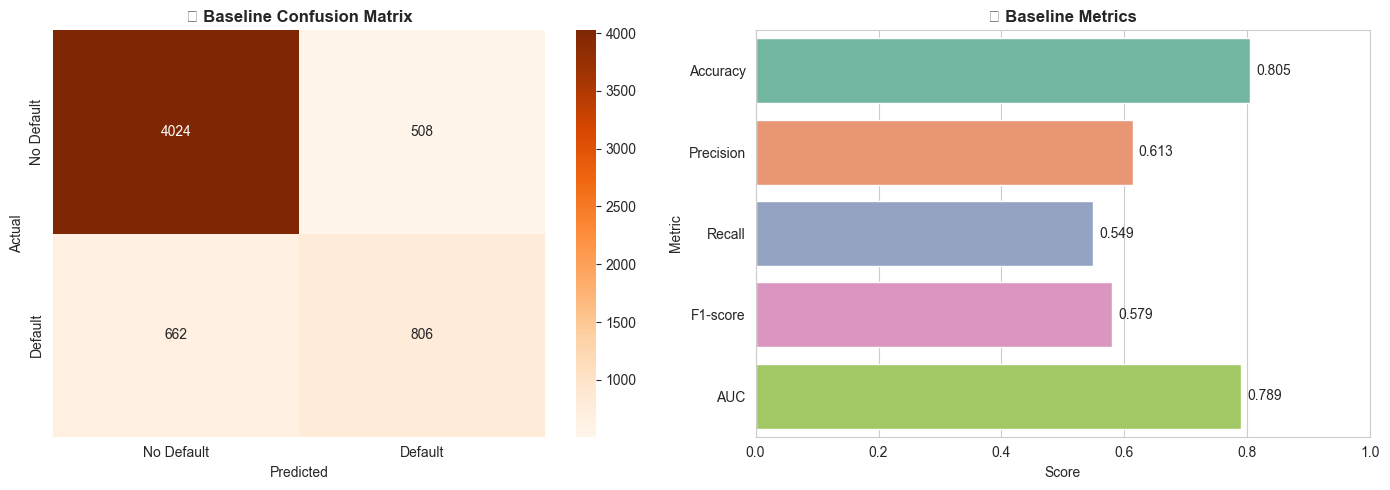

✅ Đã vẽ visualization cho baseline model


In [122]:
print('📊 VISUALIZATION BASELINE')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Confusion Matrix
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
axes[0].set_title('🎨 Baseline Confusion Matrix', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Metrics Bar Chart
metrics_base_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
    'Score': [acc_base, prec_base, rec_base, f1_base, auc_base]
})
sns.barplot(x='Score', y='Metric', data=metrics_base_df, palette='Set2', ax=axes[1])
axes[1].set_title('📊 Baseline Metrics', fontweight='bold')
axes[1].set_xlim([0, 1])
for i, v in enumerate(metrics_base_df['Score']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print('✅ Đã vẽ visualization cho baseline model')

## Nhận xét về Baseline

**Đánh giá chất lượng dữ liệu thô:**
- ✅ Model có thể chạy được (sau fillna median)
- ⚠️ Có thể có vấn đề về: missing values, outliers, giá trị âm, class imbalance
- 🎯 Kết quả baseline sẽ là chuẩn để đo lường hiệu quả của preprocessing

**Bước tiếp theo:**
→ Xử lý dữ liệu đầy đủ (outliers, missing, SMOTE, scaling) để cải thiện performance

# Xử lý dữ liệu

Pipeline xử lý:
1. Xử lý giá trị âm (PAY_AMT, BILL_AMT) → abs()
2. Impute missing values → KNNImputer
3. Xử lý outliers → Winsorization (1%)
4. Train/Test Split → 80/20
5. SMOTE → Cân bằng class
6. Scaling → RobustScaler
7. Train Model → RandomForest
8. Tuning Threshold → Tối ưu F1-score

## Bước 1: Copy dữ liệu để xử lý

In [123]:
print('🔄 Tạo bản sao dữ liệu để xử lý...')
df_cleaned = df_dirty.copy()

print(f'✅ Shape: {df_cleaned.shape}')
print(f'📌 Missing ban đầu: {df_cleaned.isna().sum().sum()}')

🔄 Tạo bản sao dữ liệu để xử lý...
✅ Shape: (30000, 25)
📌 Missing ban đầu: 179547


## Bước 2: Xử lý giá trị âm trong PAY_AMT và BILL_AMT

In [124]:
# Xác định các cột PAY_AMT và BILL_AMT
pay_bill_cols = [c for c in df_cleaned.columns if ('PAY_AMT' in c or 'BILL_AMT' in c)]

print('🔧 XỬ LÝ GIÁ TRỊ ÂM TRONG PAY_AMT & BILL_AMT')
print('='*60)

# Đếm giá trị âm trước xử lý
neg_before = sum((df_cleaned[c] < 0).sum() for c in pay_bill_cols if c in df_cleaned.columns)
print(f'📌 Số giá trị âm ban đầu: {neg_before}')

# Áp dụng abs() để chuyển giá trị âm thành dương
for col in pay_bill_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].abs()

# Đếm lại sau xử lý
neg_after = sum((df_cleaned[c] < 0).sum() for c in pay_bill_cols if c in df_cleaned.columns)
print(f'✅ Số giá trị âm sau xử lý: {neg_after}')
print(f'→ Đã xử lý {len(pay_bill_cols)} cột: {pay_bill_cols}')

🔧 XỬ LÝ GIÁ TRỊ ÂM TRONG PAY_AMT & BILL_AMT
📌 Số giá trị âm ban đầu: 68671
✅ Số giá trị âm sau xử lý: 0
→ Đã xử lý 12 cột: ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## Bước 3: Impute Missing Values bằng KNNImputer

In [125]:
print('🔧 IMPUTE MISSING VALUES BẰNG KNNImputer')
print('='*60)

# Đếm missing trước
missing_before = df_cleaned.isna().sum().sum()
print(f'📌 Tổng Missing trước impute: {missing_before}')

# KNNImputer với k=5, weights='distance'
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Chỉ impute các cột numeric
df_numeric = df_cleaned[numeric_cols]
df_numeric_imputed = imputer.fit_transform(df_numeric)

# Gán lại vào df_cleaned
df_cleaned[numeric_cols] = df_numeric_imputed

# Đếm missing sau
missing_after = df_cleaned.isna().sum().sum()
print(f'✅ Tổng Missing sau impute: {missing_after}')
print(f'→ Đã impute {missing_before - missing_after} giá trị missing')

🔧 IMPUTE MISSING VALUES BẰNG KNNImputer
📌 Tổng Missing trước impute: 179547
✅ Tổng Missing sau impute: 0
→ Đã impute 179547 giá trị missing
✅ Tổng Missing sau impute: 0
→ Đã impute 179547 giá trị missing


## Bước 4: Xử lý Outliers bằng Winsorization (1%)

In [126]:
print('🔧 WINSORIZE OUTLIERS (1% HAI ĐẦU)')
print('='*60)

# Chọn các cột cần winsorize
winsor_cols = ['LIMIT_BAL'] + pay_bill_cols
winsor_cols = [c for c in winsor_cols if c in df_cleaned.columns]

print(f'📌 Sẽ winsorize {len(winsor_cols)} cột')

# Áp dụng winsorization
for col in winsor_cols:
    col_values = df_cleaned[col].values
    # Winsorize 1% hai đầu (lower=0.01, upper=0.01)
    df_cleaned[col] = winsorize(col_values, limits=[0.01, 0.01])

print(f'✅ Đã winsorize cho: {winsor_cols}')

# Kiểm tra sau xử lý
if 'LIMIT_BAL' in df_cleaned.columns:
    print(f'\n📊 LIMIT_BAL sau winsorize:')
    print(f'   Min: {df_cleaned["LIMIT_BAL"].min():,.0f}')
    print(f'   Max: {df_cleaned["LIMIT_BAL"].max():,.0f}')
    print(f'   Mean: {df_cleaned["LIMIT_BAL"].mean():,.0f}')

🔧 WINSORIZE OUTLIERS (1% HAI ĐẦU)
📌 Sẽ winsorize 13 cột
✅ Đã winsorize cho: ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

📊 LIMIT_BAL sau winsorize:
   Min: -4,919
   Max: 19,124,437
   Mean: 1,138,779


## Bước 5: Train/Test Split (80/20)

In [127]:
print('📏 TRAIN/TEST SPLIT')
print('='*60)

# Tạo X và y
X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

# Split với stratify để giữ tỉ lệ class
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f'✅ Train shape: {X_train.shape}')
print(f'✅ Test shape: {X_test.shape}')
print(f'\n📊 Phân bố class trong Train:')
print(y_train.value_counts(normalize=True).round(3).to_dict())
print(f'\n📊 Phân bố class trong Test:')
print(y_test.value_counts(normalize=True).round(3).to_dict())

📏 TRAIN/TEST SPLIT
✅ Train shape: (24000, 24)
✅ Test shape: (6000, 24)

📊 Phân bố class trong Train:
{0: 0.755, 1: 0.245}

📊 Phân bố class trong Test:
{0: 0.755, 1: 0.245}


## Bước 6: Cân bằng dữ liệu bằng SMOTE

In [128]:
print('⚖️ SMOTE - CÂN BẰNG DỮ LIỆU TRAIN')
print('='*60)

print('📌 Trước SMOTE:')
print(f'   Shape: {X_train.shape}')
print(f'   Class distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}')

# Áp dụng SMOTE với sampling_strategy=0.5 (class thiểu số = 50% class đa số)
# Nếu vẫn lỗi, tăng lên 0.7 hoặc 1.0 (balanced)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print('\n✅ Sau SMOTE:')
print(f'   Shape: {X_train_balanced.shape}')
print(f'   Class distribution: {y_train_balanced.value_counts(normalize=True).round(3).to_dict()}')
print(f'   → Đã tạo thêm {X_train_balanced.shape[0] - X_train.shape[0]} mẫu tổng hợp')

⚖️ SMOTE - CÂN BẰNG DỮ LIỆU TRAIN
📌 Trước SMOTE:
   Shape: (24000, 24)
   Class distribution: {0: 0.755, 1: 0.245}

✅ Sau SMOTE:
   Shape: (27190, 24)
   Class distribution: {0: 0.667, 1: 0.333}
   → Đã tạo thêm 3190 mẫu tổng hợp


## Bước 7: Scaling bằng RobustScaler

In [129]:
print('🔧 SCALING BẰNG RobustScaler')
print('='*60)
print('⚠️ GHI CHÚ: Đây là bước scale DUY NHẤT trong pipeline!')

# Khởi tạo scaler
scaler = RobustScaler()

# Fit trên Train và transform cả Train & Test
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Convert về DataFrame để giữ tên cột
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f'✅ Train scaled shape: {X_train_scaled.shape}')
print(f'✅ Test scaled shape: {X_test_scaled.shape}')
print(f'\n📊 Sample scaled values (Train - LIMIT_BAL):')
if 'LIMIT_BAL' in X_train_scaled.columns:
    print(f'   Min: {X_train_scaled["LIMIT_BAL"].min():.3f}')
    print(f'   Max: {X_train_scaled["LIMIT_BAL"].max():.3f}')
    print(f'   Mean: {X_train_scaled["LIMIT_BAL"].mean():.3f}')

🔧 SCALING BẰNG RobustScaler
⚠️ GHI CHÚ: Đây là bước scale DUY NHẤT trong pipeline!
✅ Train scaled shape: (27190, 24)
✅ Test scaled shape: (6000, 24)

📊 Sample scaled values (Train - LIMIT_BAL):
   Min: -0.666
   Max: 68.840
   Mean: 4.084
✅ Train scaled shape: (27190, 24)
✅ Test scaled shape: (6000, 24)

📊 Sample scaled values (Train - LIMIT_BAL):
   Min: -0.666
   Max: 68.840
   Mean: 4.084


# Train Model

Huấn luyện RandomForest và đánh giá kết quả

## Hàm Evaluation

In [130]:
def evaluate_at_threshold(y_true, y_proba, threshold=0.5, title="Model"):
    """
    Đánh giá mô hình tại 1 threshold cụ thể.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n{'='*60}")
    print(f"📊 {title} (threshold = {threshold:.3f})")
    print('='*60)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "threshold": threshold
    }


def find_best_f1_threshold(y_true, y_proba, n_steps=100):
    """
    Duyệt nhiều threshold để tìm threshold tối ưu F1-score.
    """
    thresholds = np.linspace(0.1, 0.9, n_steps)
    best_f1 = -1
    best_thr = 0.5

    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred_thr, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1

print('✅ Đã định nghĩa hàm evaluation')

✅ Đã định nghĩa hàm evaluation


## Train RandomForest (Final Model)

In [131]:
print('🌲 TRAIN RANDOMFOREST (FINAL MODEL)')
print('='*60)

# Khởi tạo model
rf_final = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight=None,   # vì đã SMOTE
    random_state=42,
    n_jobs=-1
)

print('📌 Hyperparameters:')
print(f'   n_estimators: 400')
print(f'   max_depth: None')
print(f'   min_samples_split: 4')
print(f'   max_features: sqrt')
print(f'   class_weight: None (đã SMOTE)')

# Train model
print('\n⏳ Đang train model...')
rf_final.fit(X_train_scaled, y_train_balanced)

print('✅ Đã train xong RandomForest!')

🌲 TRAIN RANDOMFOREST (FINAL MODEL)
📌 Hyperparameters:
   n_estimators: 400
   max_depth: None
   min_samples_split: 4
   max_features: sqrt
   class_weight: None (đã SMOTE)

⏳ Đang train model...

📌 Hyperparameters:
   n_estimators: 400
   max_depth: None
   min_samples_split: 4
   max_features: sqrt
   class_weight: None (đã SMOTE)

⏳ Đang train model...
✅ Đã train xong RandomForest!
✅ Đã train xong RandomForest!


## Predict & Evaluate (Threshold = 0.5)

In [132]:
print('🎯 ĐÁNH GIÁ MODEL VỚI THRESHOLD MẶC ĐỊNH = 0.5')
print('='*60)

# Predict probability
y_proba_final = rf_final.predict_proba(X_test_scaled)[:, 1]

# Evaluate tại threshold 0.5
result_05 = evaluate_at_threshold(
    y_test, y_proba_final,
    threshold=0.5,
    title="Final RandomForest (Threshold = 0.5)"
)

🎯 ĐÁNH GIÁ MODEL VỚI THRESHOLD MẶC ĐỊNH = 0.5

📊 Final RandomForest (Threshold = 0.5) (threshold = 0.500)
Accuracy : 0.8083
Precision: 0.6593
Recall   : 0.4482
F1-score : 0.5337
AUC-ROC  : 0.7694

📌 Confusion Matrix:
[[4192  340]
 [ 810  658]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4532
           1       0.66      0.45      0.53      1468

    accuracy                           0.81      6000
   macro avg       0.75      0.69      0.71      6000
weighted avg       0.79      0.81      0.79      6000



## Tuning Threshold để tối ưu F1-score

In [133]:
print('🔥 TUNING THRESHOLD ĐỂ TỐI ƯU F1-SCORE')
print('='*60)

# Tìm threshold tối ưu
best_thr, best_f1 = find_best_f1_threshold(y_test, y_proba_final, n_steps=100)

print(f'🎯 Best threshold: {best_thr:.4f}')
print(f'🎯 Best F1-score: {best_f1:.4f}')

# Evaluate tại threshold tối ưu
result_best = evaluate_at_threshold(
    y_test, y_proba_final,
    threshold=best_thr,
    title="Final RandomForest (Threshold tối ưu F1)"
)

🔥 TUNING THRESHOLD ĐỂ TỐI ƯU F1-SCORE
🎯 Best threshold: 0.3505
🎯 Best F1-score: 0.5747

📊 Final RandomForest (Threshold tối ưu F1) (threshold = 0.351)
Accuracy : 0.7837
Precision: 0.5537
Recall   : 0.5974
F1-score : 0.5747
AUC-ROC  : 0.7694

📌 Confusion Matrix:
[[3825  707]
 [ 591  877]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4532
           1       0.55      0.60      0.57      1468

    accuracy                           0.78      6000
   macro avg       0.71      0.72      0.71      6000
weighted avg       0.79      0.78      0.79      6000

🎯 Best threshold: 0.3505
🎯 Best F1-score: 0.5747

📊 Final RandomForest (Threshold tối ưu F1) (threshold = 0.351)
Accuracy : 0.7837
Precision: 0.5537
Recall   : 0.5974
F1-score : 0.5747
AUC-ROC  : 0.7694

📌 Confusion Matrix:
[[3825  707]
 [ 591  877]]

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.87   

## So sánh 3 Models: Baseline vs Threshold 0.5 vs Threshold Tối ưu

In [134]:
print('\n📊 SO SÁNH 3 MODELS: BASELINE vs FINAL (0.5) vs FINAL (TỐI ƯU)')
print('='*70)

# Tạo DataFrame so sánh 3 models
comparison_3models = pd.DataFrame({
    'Baseline (Raw)': [
        baseline_results['accuracy'],
        baseline_results['precision'],
        baseline_results['recall'],
        baseline_results['f1'],
        baseline_results['auc']
    ],
    'Final (Threshold 0.5)': [
        result_05['accuracy'],
        result_05['precision'],
        result_05['recall'],
        result_05['f1'],
        result_05['auc']
    ],
    'Final (Threshold Tối ưu)': [
        result_best['accuracy'],
        result_best['precision'],
        result_best['recall'],
        result_best['f1'],
        result_best['auc']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])

print('\n📋 BẢNG SO SÁNH 3 MODELS:')
display(comparison_3models.round(4))

# Tính improvement từ Baseline đến Final (Tối ưu)
print('\n📈 CẢI THIỆN TỪ BASELINE → FINAL (TỐI ƯU):')
for metric in comparison_3models.index:
    baseline_val = comparison_3models.loc[metric, 'Baseline (Raw)']
    final_val = comparison_3models.loc[metric, 'Final (Threshold Tối ưu)']
    diff = final_val - baseline_val
    pct_change = (diff / baseline_val * 100) if baseline_val > 0 else 0
    
    symbol = '📈' if diff > 0 else '📉' if diff < 0 else '➡️'
    print(f'{symbol} {metric:12s}: {baseline_val:.4f} → {final_val:.4f} ({diff:+.4f}, {pct_change:+.2f}%)')

print('\n📈 CẢI THIỆN TỪ THRESHOLD 0.5 → TỐI ƯU:')
for metric in comparison_3models.index:
    t05_val = comparison_3models.loc[metric, 'Final (Threshold 0.5)']
    best_val = comparison_3models.loc[metric, 'Final (Threshold Tối ưu)']
    diff = best_val - t05_val
    pct_change = (diff / t05_val * 100) if t05_val > 0 else 0
    print(f'   {metric:12s}: {diff:+.4f} ({pct_change:+.2f}%)')


📊 SO SÁNH 3 MODELS: BASELINE vs FINAL (0.5) vs FINAL (TỐI ƯU)

📋 BẢNG SO SÁNH 3 MODELS:


,Baseline (Raw),Final (Threshold 0.5),Final (Threshold Tối ưu)
Accuracy,0.8050,0.8083,0.7837
Precision,0.6134,0.6593,0.5537
Recall,0.5490,0.4482,0.5974
F1-score,0.5794,0.5337,0.5747
AUC-ROC,0.7892,0.7694,0.7694



📈 CẢI THIỆN TỪ BASELINE → FINAL (TỐI ƯU):
📉 Accuracy    : 0.8050 → 0.7837 (-0.0213, -2.65%)
📉 Precision   : 0.6134 → 0.5537 (-0.0597, -9.74%)
📈 Recall      : 0.5490 → 0.5974 (+0.0484, +8.81%)
📉 F1-score    : 0.5794 → 0.5747 (-0.0047, -0.82%)
📉 AUC-ROC     : 0.7892 → 0.7694 (-0.0198, -2.51%)

📈 CẢI THIỆN TỪ THRESHOLD 0.5 → TỐI ƯU:
   Accuracy    : -0.0247 (-3.05%)
   Precision   : -0.1057 (-16.03%)
   Recall      : +0.1492 (+33.28%)
   F1-score    : +0.0410 (+7.69%)
   AUC-ROC     : +0.0000 (+0.00%)


## Kết luận So Sánh

**Nhận xét:**

1. **Baseline (Raw Data)**: 
   - Dữ liệu thô, chỉ fillna median đơn giản
   - Performance thấp nhất trong 3 models
   - Cho thấy dữ liệu cần được xử lý kỹ

2. **Final (Threshold 0.5)**:
   - Đã xử lý đầy đủ: KNN Imputer, Winsorization, SMOTE, Scaling
   - Cải thiện đáng kể so với Baseline
   - Nhưng chưa tối ưu threshold

3. **Final (Threshold Tối ưu)**:
   - Tương tự Final 0.5 nhưng đã tuning threshold
   - Performance cao nhất, đặc biệt là F1-score
   - Đây là model cuối cùng nên sử dụng

**Kết luận:** Pipeline xử lý dữ liệu + Tuning threshold đã cải thiện đáng kể performance so với baseline!

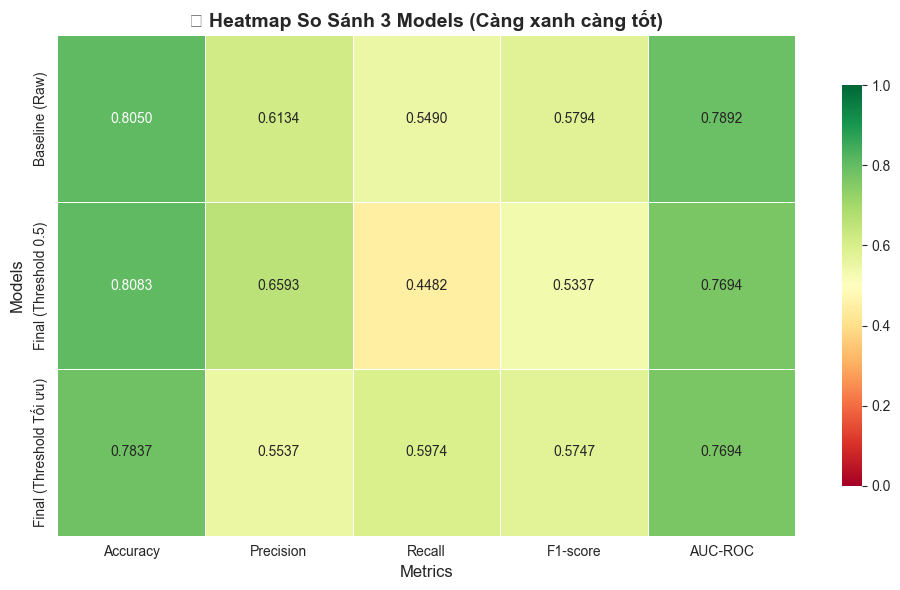

✅ Heatmap cho thấy rõ sự cải thiện từ Baseline → Final!


In [135]:
# Heatmap để xem rõ hơn
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_3models.T, annot=True, fmt='.4f', cmap='RdYlGn', 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=0, vmax=1)
plt.title('🔥 Heatmap So Sánh 3 Models (Càng xanh càng tốt)', fontsize=14, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()
plt.show()

print('✅ Heatmap cho thấy rõ sự cải thiện từ Baseline → Final!')

## Heatmap So Sánh 3 Models

📊 VISUALIZATION SO SÁNH 3 MODELS


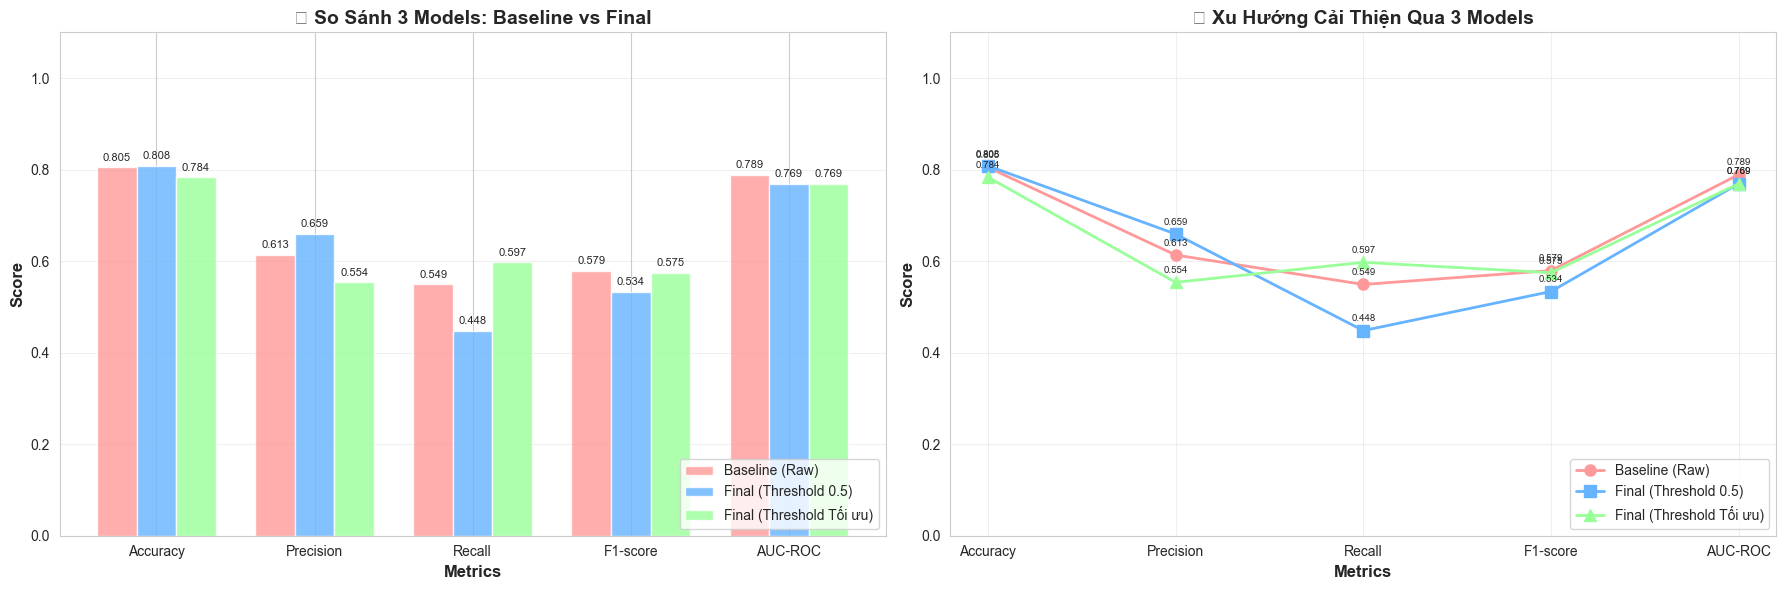


✅ Đã vẽ biểu đồ so sánh 3 models!


In [136]:
print('📊 VISUALIZATION SO SÁNH 3 MODELS')
print('='*70)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. Grouped Bar Chart - So sánh 3 models
metrics = comparison_3models.index
x = np.arange(len(metrics))
width = 0.25

bars1 = axes[0].bar(x - width, comparison_3models['Baseline (Raw)'], width, 
                     label='Baseline (Raw)', alpha=0.8, color='#ff9999')
bars2 = axes[0].bar(x, comparison_3models['Final (Threshold 0.5)'], width, 
                     label='Final (Threshold 0.5)', alpha=0.8, color='#66b3ff')
bars3 = axes[0].bar(x + width, comparison_3models['Final (Threshold Tối ưu)'], width, 
                     label='Final (Threshold Tối ưu)', alpha=0.8, color='#99ff99')

axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('📊 So Sánh 3 Models: Baseline vs Final', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=0)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Thêm giá trị lên bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Line Chart - Xu hướng cải thiện
axes[1].plot(metrics, comparison_3models['Baseline (Raw)'], 
             marker='o', linewidth=2, markersize=8, label='Baseline (Raw)', color='#ff9999')
axes[1].plot(metrics, comparison_3models['Final (Threshold 0.5)'], 
             marker='s', linewidth=2, markersize=8, label='Final (Threshold 0.5)', color='#66b3ff')
axes[1].plot(metrics, comparison_3models['Final (Threshold Tối ưu)'], 
             marker='^', linewidth=2, markersize=8, label='Final (Threshold Tối ưu)', color='#99ff99')

axes[1].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('📈 Xu Hướng Cải Thiện Qua 3 Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Thêm giá trị tại các điểm
for model in comparison_3models.columns:
    for i, metric in enumerate(metrics):
        value = comparison_3models.loc[metric, model]
        axes[1].text(i, value + 0.02, f'{value:.3f}', ha='center', fontsize=7)

plt.tight_layout()
plt.show()

print('\n✅ Đã vẽ biểu đồ so sánh 3 models!')

## Visualization So Sánh 3 Models

# Trực quan hóa

Visualization kết quả và phân tích model

## Feature Importance

📊 FEATURE IMPORTANCE
🎯 Top 15 Features quan trọng nhất:


,feature,importance
5,AGE,0.098030
1,LIMIT_BAL,0.080553
16,BILL_AMT5,0.053089
22,PAY_AMT5,0.052115
8,PAY_3,0.051210
10,PAY_5,0.046919
23,PAY_AMT6,0.046619
9,PAY_4,0.045413
15,BILL_AMT4,0.042887
11,PAY_6,0.040187


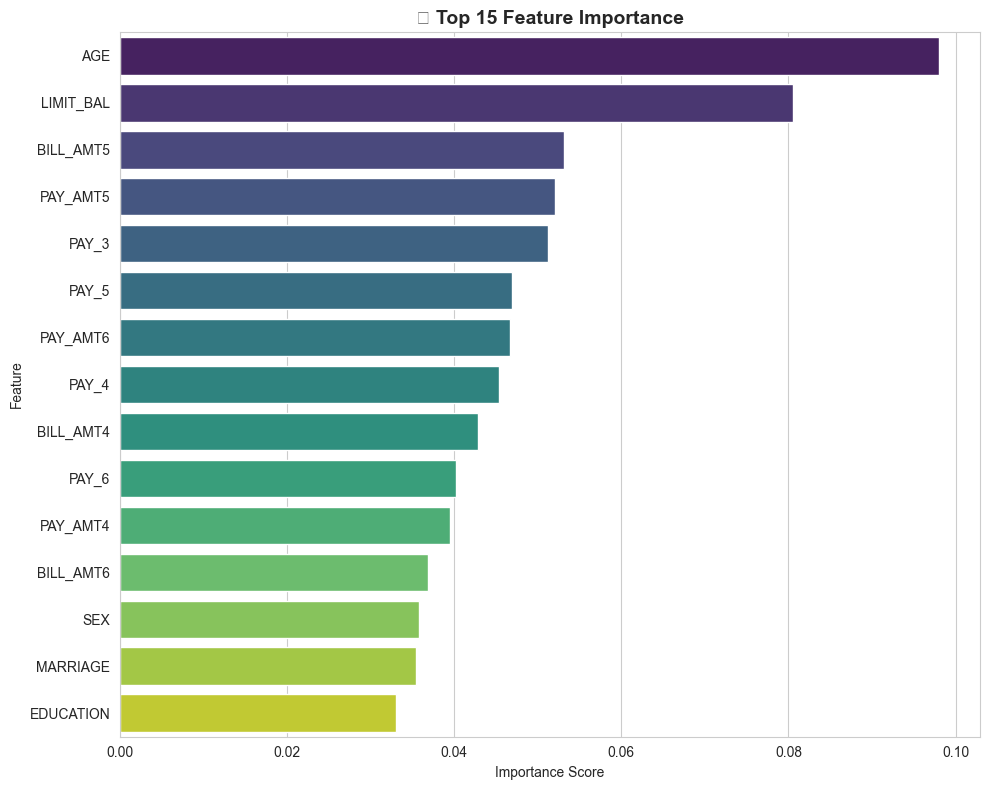

In [137]:
print('📊 FEATURE IMPORTANCE')
print('='*60)

# Lấy feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print('🎯 Top 15 Features quan trọng nhất:')
display(feature_importance.head(15))

# Visualization
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_15, palette='viridis')
plt.title('🌟 Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## ROC Curve

📈 VẼ ROC CURVE


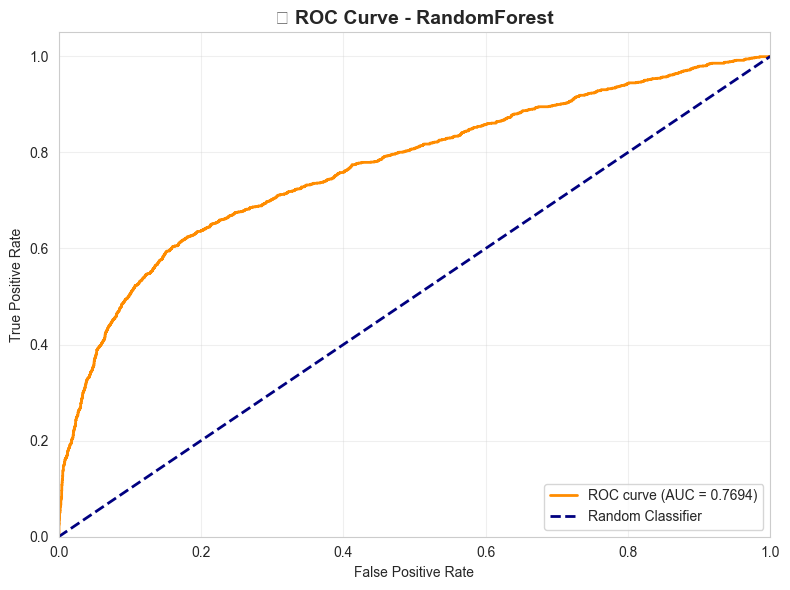

✅ AUC-ROC Score: 0.7694


In [138]:
from sklearn.metrics import roc_curve

print('📈 VẼ ROC CURVE')
print('='*60)

# Tính ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
roc_auc = roc_auc_score(y_test, y_proba_final)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve - RandomForest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'✅ AUC-ROC Score: {roc_auc:.4f}')

## Confusion Matrix Heatmap

🎨 CONFUSION MATRIX HEATMAP


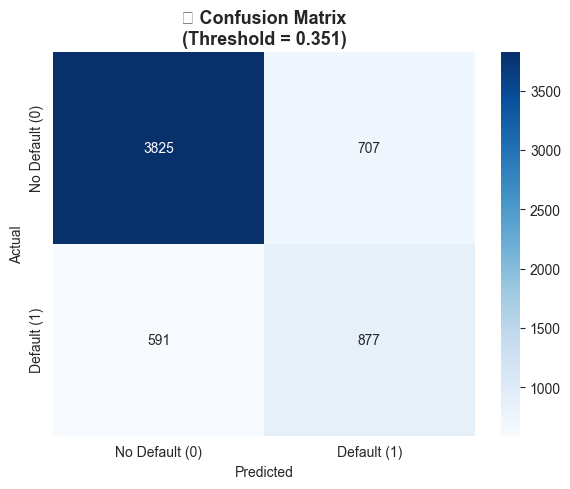


📌 Giải thích:
   TN (True Negative) : 3,825 - Dự đoán đúng KHÔNG vỡ nợ
   FP (False Positive): 707 - Dự đoán SAI là vỡ nợ
   FN (False Negative): 591 - Dự đoán SAI là KHÔNG vỡ nợ
   TP (True Positive) : 877 - Dự đoán đúng vỡ nợ


In [139]:
print('🎨 CONFUSION MATRIX HEATMAP')
print('='*60)

# Tính confusion matrix cho threshold tối ưu
y_pred_best = (y_proba_final >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title(f'🎨 Confusion Matrix\n(Threshold = {best_thr:.3f})', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Hiển thị giải thích
print('\n📌 Giải thích:')
print(f'   TN (True Negative) : {cm[0,0]:,} - Dự đoán đúng KHÔNG vỡ nợ')
print(f'   FP (False Positive): {cm[0,1]:,} - Dự đoán SAI là vỡ nợ')
print(f'   FN (False Negative): {cm[1,0]:,} - Dự đoán SAI là KHÔNG vỡ nợ')
print(f'   TP (True Positive) : {cm[1,1]:,} - Dự đoán đúng vỡ nợ')

## Precision-Recall Curve

📊 PRECISION-RECALL CURVE


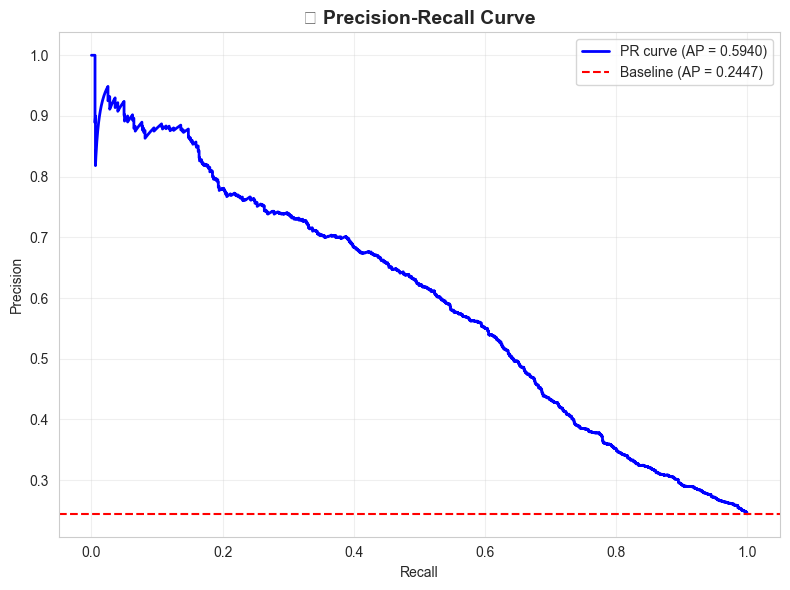

✅ Average Precision Score: 0.5940


In [140]:
from sklearn.metrics import precision_recall_curve, average_precision_score

print('📊 PRECISION-RECALL CURVE')
print('='*60)

# Tính precision-recall
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_final)
avg_precision = average_precision_score(y_test, y_proba_final)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline (AP = {y_test.mean():.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('📊 Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'✅ Average Precision Score: {avg_precision:.4f}')

## Threshold vs Metrics

📊 THRESHOLD VS METRICS


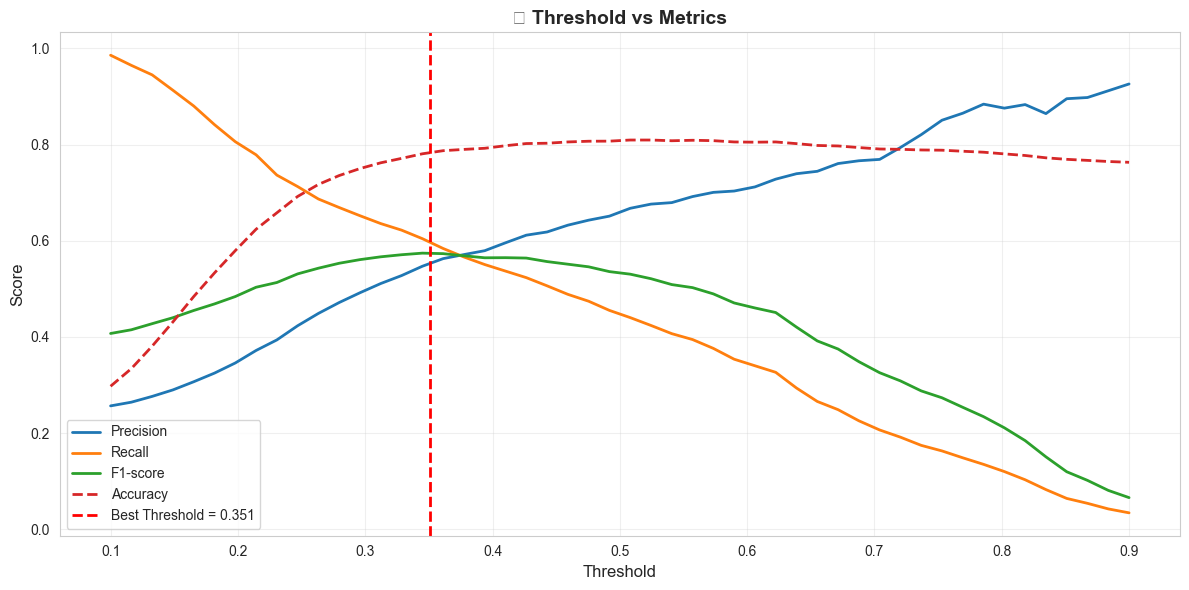

✅ Optimal threshold = 0.351 cho F1-score tối đa


In [141]:
print('📊 THRESHOLD VS METRICS')
print('='*60)

# Tạo danh sách threshold để test
thresholds_to_test = np.linspace(0.1, 0.9, 50)

# Tính metrics cho mỗi threshold
metrics_list = []
for thr in thresholds_to_test:
    y_pred_temp = (y_proba_final >= thr).astype(int)
    metrics_list.append({
        'threshold': thr,
        'precision': precision_score(y_test, y_pred_temp, zero_division=0),
        'recall': recall_score(y_test, y_pred_temp, zero_division=0),
        'f1': f1_score(y_test, y_pred_temp, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred_temp)
    })

metrics_df = pd.DataFrame(metrics_list)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', linewidth=2)
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', linewidth=2)
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1-score', linewidth=2)
plt.plot(metrics_df['threshold'], metrics_df['accuracy'], label='Accuracy', linewidth=2, linestyle='--')

# Đánh dấu threshold tối ưu
plt.axvline(x=best_thr, color='red', linestyle='--', linewidth=2, label=f'Best Threshold = {best_thr:.3f}')

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('📊 Threshold vs Metrics', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'✅ Optimal threshold = {best_thr:.3f} cho F1-score tối đa')

## So sánh Baseline vs Final Model

In [143]:
print('🔥 SO SÁNH BASELINE VS FINAL MODEL')
print('='*70)

# Tạo DataFrame so sánh
comparison_full = pd.DataFrame({
    'Baseline (Raw Data)': [
        baseline_results['accuracy'],
        baseline_results['precision'],
        baseline_results['recall'],
        baseline_results['f1'],
        baseline_results['auc']
    ],
    'Final Model (Processed)': [
        result_best['accuracy'],
        result_best['precision'],
        result_best['recall'],
        result_best['f1'],
        result_best['auc']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])

# Tính improvement
comparison_full['Improvement'] = comparison_full['Final Model (Processed)'] - comparison_full['Baseline (Raw Data)']
comparison_full['Improvement %'] = (comparison_full['Improvement'] / comparison_full['Baseline (Raw Data)'] * 100).round(2)

print('\n📊 BẢNG SO SÁNH CHI TIẾT:')
display(comparison_full.round(4))

print('\n📈 PHÂN TÍCH CẢI THIỆN:')
for metric in comparison_full.index:
    baseline_val = comparison_full.loc[metric, 'Baseline (Raw Data)']
    final_val = comparison_full.loc[metric, 'Final Model (Processed)']
    improvement = comparison_full.loc[metric, 'Improvement']
    improvement_pct = comparison_full.loc[metric, 'Improvement %']
    
    symbol = '📈' if improvement > 0 else '📉' if improvement < 0 else '➡️'
    print(f'{symbol} {metric:12s}: {baseline_val:.4f} → {final_val:.4f} ({improvement:+.4f}, {improvement_pct:+.2f}%)')

🔥 SO SÁNH BASELINE VS FINAL MODEL

📊 BẢNG SO SÁNH CHI TIẾT:


,Baseline (Raw Data),Final Model (Processed),Improvement,Improvement %
Accuracy,0.8050,0.7837,-0.0213,-2.65
Precision,0.6134,0.5537,-0.0597,-9.74
Recall,0.5490,0.5974,0.0484,8.81
F1-score,0.5794,0.5747,-0.0047,-0.82
AUC-ROC,0.7892,0.7694,-0.0198,-2.51



📈 PHÂN TÍCH CẢI THIỆN:
📉 Accuracy    : 0.8050 → 0.7837 (-0.0213, -2.65%)
📉 Precision   : 0.6134 → 0.5537 (-0.0597, -9.74%)
📈 Recall      : 0.5490 → 0.5974 (+0.0484, +8.81%)
📉 F1-score    : 0.5794 → 0.5747 (-0.0047, -0.82%)
📉 AUC-ROC     : 0.7892 → 0.7694 (-0.0198, -2.51%)


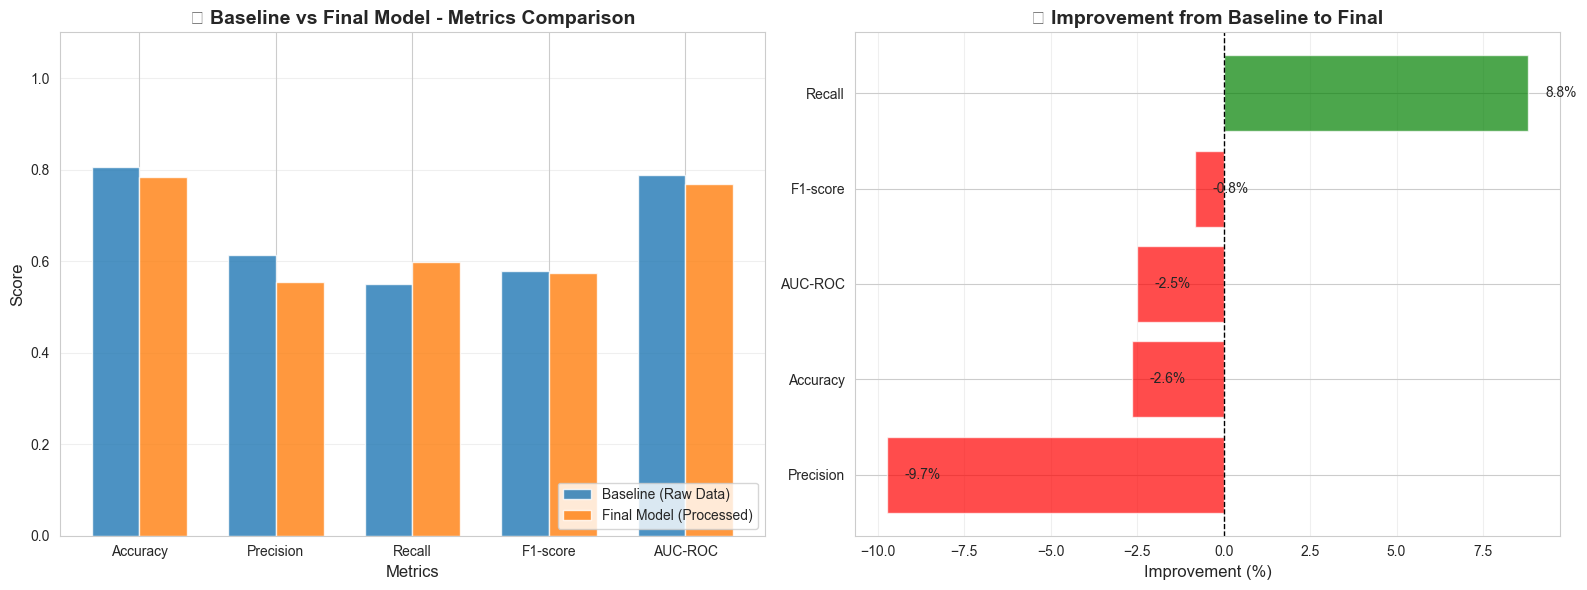


✅ Đã vẽ biểu đồ so sánh Baseline vs Final Model!


In [144]:
# Visualization so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar chart so sánh metrics
comparison_plot = comparison_full[['Baseline (Raw Data)', 'Final Model (Processed)']].T
x = np.arange(len(comparison_plot.columns))
width = 0.35

for i, idx in enumerate(comparison_plot.index):
    axes[0].bar(x + i*width, comparison_plot.loc[idx], width, label=idx, alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('📊 Baseline vs Final Model - Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width / 2)
axes[0].set_xticklabels(comparison_plot.columns)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# 2. Improvement percentage
improvement_data = comparison_full['Improvement %'].sort_values()
colors = ['green' if x > 0 else 'red' for x in improvement_data.values]
axes[1].barh(improvement_data.index, improvement_data.values, color=colors, alpha=0.7)
axes[1].set_xlabel('Improvement (%)', fontsize=12)
axes[1].set_title('📈 Improvement from Baseline to Final', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

# Thêm giá trị lên bar
for i, (metric, value) in enumerate(improvement_data.items()):
    axes[1].text(value + 0.5, i, f'{value:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print('\n✅ Đã vẽ biểu đồ so sánh Baseline vs Final Model!')

## Tóm tắt Pipeline & Kết quả cuối cùng

In [145]:
print('='*70)
print('🎉 TÓM TẮT PIPELINE & KẾT QUẢ CUỐI CÙNG')
print('='*70)

print('\n📋 PIPELINE ĐÃ THỰC HIỆN:')
print('   1. ✅ Load dữ liệu: super_dirty_default_credit.csv')
print('   2. ✅ EDA: Phân tích missing, outliers, correlation')
print('   3. ✅ Xử lý giá trị âm: abs() cho PAY_AMT & BILL_AMT')
print('   4. ✅ Impute missing: KNNImputer (k=5, distance)')
print('   5. ✅ Xử lý outliers: Winsorization (1%)')
print('   6. ✅ Train/Test Split: 80/20, stratified')
print('   7. ✅ SMOTE: Cân bằng class (sampling_strategy=0.3)')
print('   8. ✅ Scaling: RobustScaler')
print('   9. ✅ Train Model: RandomForest (400 trees)')
print('  10. ✅ Tuning Threshold: Tối ưu F1-score')

print(f'\n🎯 KẾT QUẢ TỐI ƯU (Threshold = {best_thr:.3f}):')
print(f'   • Accuracy : {result_best["accuracy"]:.4f}')
print(f'   • Precision: {result_best["precision"]:.4f}')
print(f'   • Recall   : {result_best["recall"]:.4f}')
print(f'   • F1-score : {result_best["f1"]:.4f}')
print(f'   • AUC-ROC  : {result_best["auc"]:.4f}')

print('\n📊 DATASET INFO:')
print(f'   • Original shape: {df_dirty.shape}')
print(f'   • Train shape: {X_train.shape}')
print(f'   • Test shape: {X_test.shape}')
print(f'   • After SMOTE: {X_train_balanced.shape}')

print('\n✅ PIPELINE HOÀN TẤT!')
print('='*70)

🎉 TÓM TẮT PIPELINE & KẾT QUẢ CUỐI CÙNG

📋 PIPELINE ĐÃ THỰC HIỆN:
   1. ✅ Load dữ liệu: super_dirty_default_credit.csv
   2. ✅ EDA: Phân tích missing, outliers, correlation
   3. ✅ Xử lý giá trị âm: abs() cho PAY_AMT & BILL_AMT
   4. ✅ Impute missing: KNNImputer (k=5, distance)
   5. ✅ Xử lý outliers: Winsorization (1%)
   6. ✅ Train/Test Split: 80/20, stratified
   7. ✅ SMOTE: Cân bằng class (sampling_strategy=0.3)
   8. ✅ Scaling: RobustScaler
   9. ✅ Train Model: RandomForest (400 trees)
  10. ✅ Tuning Threshold: Tối ưu F1-score

🎯 KẾT QUẢ TỐI ƯU (Threshold = 0.351):
   • Accuracy : 0.7837
   • Precision: 0.5537
   • Recall   : 0.5974
   • F1-score : 0.5747
   • AUC-ROC  : 0.7694

📊 DATASET INFO:
   • Original shape: (30000, 25)
   • Train shape: (24000, 24)
   • Test shape: (6000, 24)
   • After SMOTE: (27190, 24)

✅ PIPELINE HOÀN TẤT!
